In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
# Kianoush Aqabakee
# Apache License 2.0
class Genetic_algorithm:
    def __init__(self,MaxIt=51,nPop=20
                 ,pc=10,pm=10,gamma=0.2,mu=0.4,beta=8,VarMin=-10,VarMax= 10):
        self.MaxIt=MaxIt
        self.nPop=nPop
        self.pc=pc
        self.pm=pm
        self.gamma=gamma
        self.mu=mu
        self.beta=beta
        self.VarMin=VarMin
        self.VarMax=VarMax
    def RouletteWheelSelection(self,P):
        r=np.random.rand();
        C=np.zeros([self.nPop]);
        c0=0;
        for k1 in range(0,self.nPop):
            C[k1]=c0+P[k1];
            c0=C[k1];
        flag=1;
        for k1 in range(0,self.nPop):
                if (r<=C[k1] and flag==1):
                    i=[k1];
                    flag=0;
                else:
                    i=np.random.randint(0,self.nPop);
        return i
    def Crossover(self,i1,i2):
        x1=np.copy(self.popPosition[i1])
        x2=np.copy(self.popPosition[i2])
        alpha=np.random.uniform(-self.gamma,1+self.gamma,x1.size);
        y=np.zeros([2,x1.size]);
        x1=np.array(x1)
        x2=np.array(x2)
        alpha=np.array(alpha)
        y[0]=alpha*x1+(1-alpha)*x2;
        y[1]=alpha*x2+(1-alpha)*x1;

        y=np.clip(y,self.VarMin,self.VarMax)
        return y
    def Mutate(self,index):
        x=np.copy(self.popPosition[index])
        nVar=x.size;
        nmu=int(np.ceil(self.mu*nVar));
        sigma=0.1*(self.VarMax-self.VarMin);
        j=np.random.randint(0,nVar,nmu);
        y=x;
        y[j]=y[j]+sigma*np.random.randint(nmu+1)
        y=np.clip(y,self.VarMin,self.VarMax)
        
        return y
    def GA(self,fobj,n_params,initial_value=[]):#'dont have'):
        nm=round(self.pm*self.nPop)
        nc=2*round(self.pc*self.nPop/2)
        ## Initializations
        maxCosts=-100000;
        minCosts=100000;
        popPosition_r = np.random.rand(self.nPop,initial_value.shape[0])
        self.popPosition=self.VarMin+popPosition_r*(self.VarMax-self.VarMin)
        if(any(initial_value)):#'dont have'):
            self.popPosition[0,:]=initial_value
        self.popCost=np.asarray([fobj(ind) for ind in self.popPosition])

        ## Main Loop
        popcPosition=np.zeros([round(nc/2),n_params]);
        popcCost=np.zeros([round(nc/2),2]);
        popmPosition=np.zeros([nm,n_params])
        popmCost=np.zeros([nm]);
        popnew=np.zeros([self.nPop+round(nc/2)+nm,n_params]);
        popnewCost=np.zeros([self.nPop+round(nc/2)+nm]);
        Sort_popnew=np.zeros([popnew.shape[0],n_params]);
        Sort_popnewCost=np.zeros(popnew.shape[0]);
        for it in range(1,self.MaxIt):
            # Selection Probabilities
            Pr=np.zeros([self.nPop]);
            P=np.zeros([self.nPop]);
            sumPr=0;
            for i in range (0,self.nPop):
                Pr[i]=np.exp(-self.beta*self.popCost[i]/np.max(self.popCost));
                sumPr=Pr[i]+sumPr;
            for i in range (0,self.nPop):
                P[i]=Pr[i]/sumPr;
            popc=np.zeros([round(nc/2),2]);
            for k in range(0,round(nc/2)):
                # Select Parents Indices
                 i1=self.RouletteWheelSelection(P);
                 i2=self.RouletteWheelSelection(P);
                 while (i1==i2):
                     i2=self.RouletteWheelSelection(P);
                     
            # Apply Crossover
            popcPosition=self.Crossover(i1,i2);
            # Mutation
            for k in range(0,nm):
                i=np.random.randint(self.nPop)
                popmPosition[k]=self.Mutate(i);
            # Merge
            popnew=np.concatenate((self.popPosition,popcPosition,popmPosition))
            popnewCost=np.asarray([fobj(ind) for ind in popnew])

            index=np.argsort(popnewCost)
            Sort_popnewCost=np.sort(popnewCost)
            Sort_popnew=np.array([popnew[ind] for ind in index])
            # Truncation
            self.popPosition=Sort_popnew[0:self.nPop][:]
            self.popCost=Sort_popnewCost[0:self.nPop][:]
            print('Best unfitness in iteration %d: %f' % (it, self.popCost[0]))
        #print(fobj(self.popPosition[0]))
        yield self.popPosition[0],self.popCost[0]



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
##from GA import Genetic_algorithm
# Kianoush Aqabakee
# Apache License 2.0
class RBFnn():
    def __init__(self, number_of_centers):
        self.c_num=number_of_centers
    def sigma_estimator(self):
        self.sigma=np.zeros([self.input_num,self.c_num])
        dist_center=np.zeros([self.input_num,self.c_num,self.c_num])
        for uu in range(self.input_num):
            for k in range(0,self.c_num):
                for l in range(k,self.c_num):
                    dist_center[uu][k][l]=np.abs(self.centers[uu][l]-self.centers[uu][k])
        p=self.c_num*(self.c_num-1)/2
        Alpha=0.3 # Heuristically
        for uu in range(self.input_num):
            self.sigma[uu]+=Alpha/p*np.sum(dist_center[uu],axis=0)
    def H_estimator(self,inputdata):
        h=np.zeros([self.input_num,self.c_num,inputdata.shape[1]])
        for uu in range(self.input_num):
            for k in range(0,self.c_num):
                R=0.5*self.sigma[uu][k]**2*np.identity((inputdata[uu]-self.centers[uu][k]).shape[0])
                h[uu][k]=np.exp(-np.dot(np.transpose((inputdata[uu]-self.centers[uu][k])),R,(inputdata[uu]-self.centers[uu][k])))
        H=np.ones(h.shape[2])
        for uu in range(self.input_num):
            H=np.multiply(H,h[uu])
        return(np.clip(H.T,0,10**3))
    def Train(self, inputdata, targetdata, number_of_inputs):
        self.inputdata=inputdata
        self.targetdata=targetdata
        if number_of_inputs==1:
            inputdata=inputdata.reshape(1,inputdata.size)
        self.input_num=number_of_inputs
        self.centers=np.zeros([number_of_inputs,self.c_num])
        for i in range(number_of_inputs):
            XX=np.array([inputdata[i,:],inputdata[i,:]]).T
            temp=KMeans(self.c_num,max_iter=40).fit(XX).cluster_centers_
            self.centers[i,:]=temp[:, 1]
        self.sigma_estimator()
        H=self.H_estimator(inputdata)
        self.weights=np.dot(np.linalg.pinv(H), targetdata)  #  pinv is pseudu of H * Y
        ga=Genetic_algorithm(MaxIt=51)
        U_=np.reshape(self.sigma,[self.sigma.size])
        result = list(ga.GA(self.error_RBF,n_params=U_.shape[0],initial_value= U_ ,))
        #result = list(ga.GA(targetdata,inputdata,self.error_RBF,
        #                    n_params=U_.shape[0],initial_value=np.zeros(U_.shape)  ,))
        U=result[0][:]
        self.sigma=np.reshape(U[0],[self.input_num,int(U[0].size/self.input_num)])
        H=self.H_estimator(inputdata)
        self.weights=np.dot(np.linalg.pinv(H), targetdata)  #  pinv is pseudu of H * Y
    def error_RBF(self,ind):
        x=self.inputdata
        t=self.targetdata
        t=np.reshape(t,[1,t.size])
        if self.input_num==1:
            x=np.reshape(x,[1,x.size])
            ind=np.reshape(ind,[1,ind.size])
        try:
            U=ind[0][:]
        except:
            U=ind
        self.sigma=np.reshape(U,[self.input_num,int(U.size/self.input_num)])
        self.ooo2=x
        H=self.H_estimator(x)
        self.ooo=H
        self.weights=np.dot(np.linalg.pinv(H), t[0,:])
        y=self.predict(x)-t
        y=y[0][:]
        return(0.5*np.sqrt(np.sum(y**2)/x.size))
    def predict(self, inputdata):
        if self.input_num==1:
            inputdata=inputdata.reshape(1,inputdata.size)
        H=self.H_estimator(inputdata)
        return(np.dot(H,self.weights))




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Best unfitness in iteration 1: 0.020502
Best unfitness in iteration 2: 0.019241
Best unfitness in iteration 3: 0.018068
Best unfitness in iteration 4: 0.018068
Best unfitness in iteration 5: 0.017860
Best unfitness in iteration 6: 0.017860
Best unfitness in iteration 7: 0.017853
Best unfitness in iteration 8: 0.017831
Best unfitness in iteration 9: 0.017831
Best unfitness in iteration 10: 0.017831
Best unfitness in iteration 11: 0.017831
Best unfitness in iteration 12: 0.017831
Best unfitness in iteration 13: 0.017770
Best unfitness in iteration 14: 0.017770
Best unfitness in iteration 15: 0.017770
Best unfitness in iteration 16: 0.017770
Best unfitness in iteration 17: 0.017770
Best unfitness in iteration 18: 0.017769
Best unfitness in iteration 19: 0.017769
Best unfitness in iteration 20: 0.017769
Best unfitness in iteration 21: 0.017762
Best unfitness in iteration 22: 0.017762
Best unfitness in iteration 23: 0.017762
Best unfitness in iteration 24: 0.017762
Best unfitness in iterati

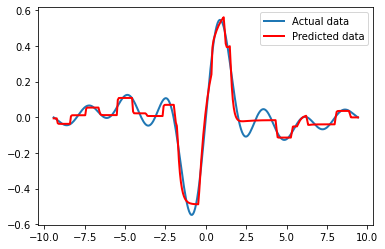

In [11]:
inputdata=np.linspace(-3*np.pi,3*np.pi,300)
targetdata=np.sinc(inputdata*0.5)*np.sin(inputdata)#(1-2*np.exp(-0.1*inputdata))

rbfQ=RBFnn(20)
rbfQ.Train(inputdata,targetdata,1)
y_hat=rbfQ.predict(inputdata)
plt.plot(inputdata,targetdata,linewidth=2.0)
plt.plot(inputdata,y_hat,'r',linewidth=2.0)
plt.legend(['Actual data','Predicted data'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


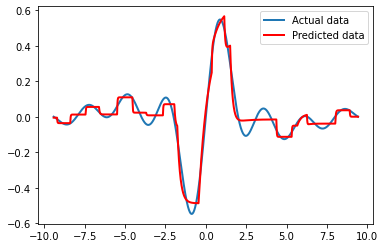

In [14]:
inputdata=np.linspace(-3*np.pi,3*np.pi,5000)
targetdata=np.sinc(inputdata*0.5)*np.sin(inputdata)#(1-2*np.exp(-0.1*inputdata))

y_hat=rbfQ.predict(inputdata)
plt.plot(inputdata,targetdata,linewidth=2.0)
plt.plot(inputdata,y_hat,'r',linewidth=2.0)
plt.legend(['Actual data','Predicted data'])
plt.show()